In [1]:
from allennlp.common import Params
from allennlp.models import Model
from allennlp.data.dataset_readers import DatasetReader
from allennlp.data import Vocabulary
from allennlp.data.dataset import Batch

from typing import Tuple, List, Dict

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
import numpy as np

In [3]:
from allennlp.common.util import import_submodules
import_submodules('al2_implementation')

In [230]:
prefix = '/home/emelyanov-yi/models/ontonotes/mrc_2/bert_finetuned/'
params = Params.from_file(prefix + 'config.json')
vocab = Vocabulary.from_files(prefix + 'vocabulary/')
reader = DatasetReader.from_params(params['dataset_reader'].duplicate())

In [231]:
data_path = params['validation_data_path']

In [232]:
model = Model.load(params.duplicate(), serialization_dir=prefix)

In [8]:
instances_gen = list(reader.read(data_path))

In [316]:
idx = 2550

In [312]:
custom_instance = reader.text_to_instance(
    ["Apple.", "Inc.", "stock", "prices", "are", "12", "dollars", "each", "in", "United", "States"],
    ['stock', 'price', ',', 'quantity'],
    [6],
    [7],
    type='random'
)

In [314]:
inst = custom_instance

In [313]:
batch = Batch([custom_instance])
batch.index_instances(vocab)
res = model.forward_on_instance(custom_instance)

In [319]:
idx += 1

In [320]:
inst = instances_gen[idx]
batch = Batch([inst])
batch.index_instances(vocab)
res = model.forward_on_instance(inst)

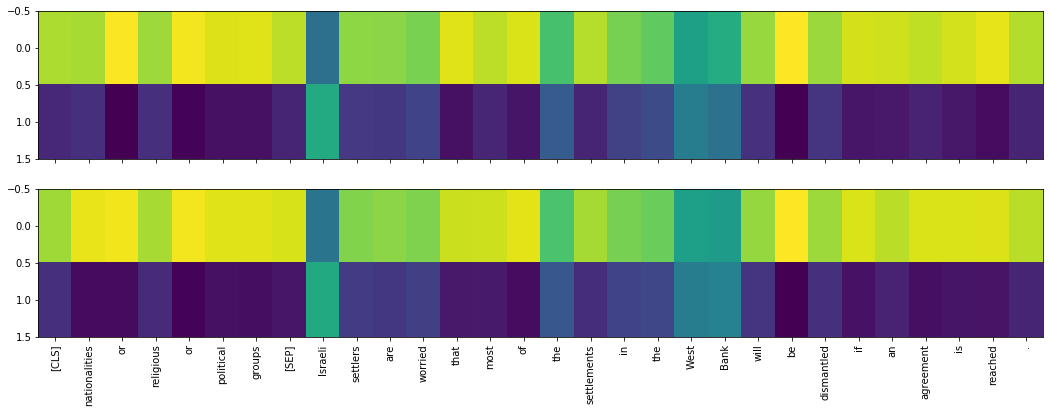

-----------Gold and prediction
[CLS] nationalities or religious or political groups [SEP]  Israeli  settlers are worried that most of the settlements in the West Bank will be dismantled if an agreement is reached .
[CLS] nationalities or religious or political groups [SEP]  Israeli  settlers are worried that most of the settlements in the West Bank will be dismantled if an agreement is reached .
------------------Meta------------
Instance with fields:
 	 context: TextField of length 30 with text: 
 		[[CLS], nationalities, or, religious, or, political, groups, [SEP], Israeli, settlers, are, worried,
		that, most, of, the, settlements, in, the, West, Bank, will, be, dismantled, if, an, agreement, is,
		reached, .]
 		and TokenIndexers : {'tokens': 'PretrainedBertIndexer'} 
 	 meta: MetadataField (print field.metadata to see specific information). 
 	 answer_starts: SequenceLabelField of length 30 with labels:
 		[False, False, False, False, False, False, False, False, True, False, False

In [323]:
# plt.figure(figsize=(18, 10))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(18, 6)
ax1.imshow(res['start_logits'].T, aspect='auto')

ax2.imshow(res['end_logits'].T, aspect='auto')
n_tokens = len(inst['context'].tokens)
ax2.set_xticks(np.linspace(0, n_tokens-1, n_tokens))
ax2.set_xticklabels(inst['context'].tokens, rotation=90)
plt.show();

print('-----------Gold and prediction')

gold_spans = get_spans_from_arrays(inst['answer_starts'].labels, inst['answer_ends'].labels)
print(highlight_answers(inst['context'], gold_spans))

predicted_spans = get_spans_from_arrays(res['start_logits'].argmax(axis=1), res['end_logits'].argmax(axis=1))
print(highlight_answers(inst['context'], predicted_spans))

print('------------------Meta------------')
print(inst)
print(inst['meta'].metadata['type'])

print('------------Prediction----------')
print(res['start_logits'].argmax(axis=1))
print(res['end_logits'].argmax(axis=1))

In [251]:
idx

1375

In [324]:
res['start_logits']

array([[ 2.782395  , -2.9405248 ],
       [ 2.7309813 , -2.7618241 ],
       [ 3.638114  , -3.756781  ],
       [ 2.60223   , -2.7402158 ],
       [ 3.5734198 , -3.6713474 ],
       [ 3.30672   , -3.4083996 ],
       [ 3.3165581 , -3.418681  ],
       [ 2.9434946 , -2.9796522 ],
       [-1.002748  ,  0.797807  ],
       [ 2.4265463 , -2.5164495 ],
       [ 2.4036345 , -2.537114  ],
       [ 2.2017083 , -2.2708464 ],
       [ 3.3296735 , -3.4356794 ],
       [ 2.952066  , -2.9651582 ],
       [ 3.280097  , -3.3371038 ],
       [ 1.5114756 , -1.5791352 ],
       [ 2.8596666 , -2.982272  ],
       [ 2.1673586 , -2.2781072 ],
       [ 1.8887377 , -2.0185227 ],
       [ 0.4772756 , -0.59847665],
       [ 0.8643899 , -0.98861694],
       [ 2.531032  , -2.7000494 ],
       [ 3.6930573 , -3.7557003 ],
       [ 2.5775108 , -2.6150634 ],
       [ 3.2270222 , -3.319125  ],
       [ 3.1592734 , -3.2525392 ],
       [ 2.9930344 , -3.0423417 ],
       [ 3.1773696 , -3.2893434 ],
       [ 3.4073944 ,

In [93]:
get_spans_from_arrays(inst['answer_starts'].labels, inst['answer_ends'].labels)

[(5, 7)]

In [62]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [98]:
def get_spans_from_arrays(starts: List[int], ends: List[int]) -> List:
    spans: List[Tuple[int, int]] = []
    start_idx = 0
    inside = False
    for i in range(len(starts)):
        if starts[i]:
            inside = True
            start_idx = i
        if ends[i] and inside:
            spans.append((start_idx, i))
            inside = False
    return spans

In [79]:
def highlight_answers(context: List[str], answers: List[Tuple[int, int]], color: str = bcolors.OKBLUE) -> str:
    """
    Helper function that prints answer using Python's native coloring.
    """
    buffer: List[str] = []
    answers = sorted(answers)
    starts = set(a[0] for a in answers)
    ends = set(a[1] for a in answers)
    for i, token in enumerate(context):
        if i in starts:
            buffer.append(color)
        buffer.append(str(token))
        if i in ends:
            buffer.append(bcolors.ENDC)
    return ' '.join(buffer)

In [67]:
print(highlight_answers(['1', '2', '3'], [(1, 2)]))

1  2 3 


In [57]:
res['start_logits'].T.shape

(2, 28)

In [55]:
len(inst['context'].tokens)

28

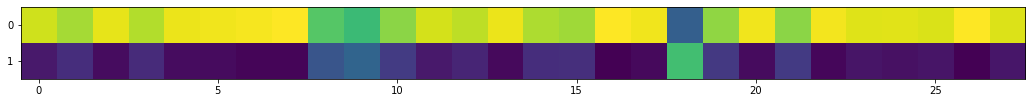

In [21]:
plt.figure(figsize=(18, 3))


In [22]:
res['start_logits'].argmax(axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [23]:
res['end_logits'].argmax(axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

Instance with fields:
 	 context: TextField of length 25 with text: 
 		[[CLS], people,, including, fictional, [SEP], Al, Gore, 's, top, campaign, aides, ,, his, children,
		,, Republican, senators, and, congressmen, ,, they, were, all, there, .]
 		and TokenIndexers : {'tokens': 'PretrainedBertIndexer'} 
 	 meta: MetadataField (print field.metadata to see specific information). 
 	 answer_starts: SequenceLabelField of length 25 with labels:
 		[False, False, False, False, False, True, False, False, False, False, False, False, False, False,
		False, False, False, False, False, False, False, False, False, False, False]
 		in namespace: 'labels'. 
 	 answer_ends: SequenceLabelField of length 25 with labels:
 		[False, False, False, False, False, False, False, True, False, False, False, False, False, False,
		False, False, False, False, False, False, False, False, False, False, False]
 		in namespace: 'labels'. 

PERSON


In [73]:
inst['answer_starts'].labels

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [40]:
ax2.get_xticks()

array([-5.,  0.,  5., 10., 15., 20., 25., 30.])

In [45]:
ax2.get_xticks()

array([-5.        , -3.7037037 , -2.40740741, -1.11111111,  0.18518519,
        1.48148148,  2.77777778,  4.07407407,  5.37037037,  6.66666667,
        7.96296296,  9.25925926, 10.55555556, 11.85185185, 13.14814815,
       14.44444444, 15.74074074, 17.03703704, 18.33333333, 19.62962963,
       20.92592593, 22.22222222, 23.51851852, 24.81481481, 26.11111111,
       27.40740741, 28.7037037 , 30.        ])

In [48]:
ax2.get_xticks()

array([ 0.        ,  0.92592593,  1.85185185,  2.77777778,  3.7037037 ,
        4.62962963,  5.55555556,  6.48148148,  7.40740741,  8.33333333,
        9.25925926, 10.18518519, 11.11111111, 12.03703704, 12.96296296,
       13.88888889, 14.81481481, 15.74074074, 16.66666667, 17.59259259,
       18.51851852, 19.44444444, 20.37037037, 21.2962963 , 22.22222222,
       23.14814815, 24.07407407, 25.        ])